In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import json
import folium

# Une planète au sommet

Il est difficile de sentir les dimensions réelles du système solaire. Une façon d'en avoir une idée est de construire un modèle réduit du système solaire en plaçant les planètes à des distances respectant les proportions. 

Si on veut aussi respecter les proportions des diamètres des planètes et du soleil, ont doit alors avoir un très grand terrain plat et vide...  
voir ce projet réalisé dans le désert du Névada: [To Scale: The Solar System](https://www.youtube.com/watch?v=zR3Igc3Rhfg) (vidéo youtube).

à Grenoble (et en France ?), il n'y a malheureusement pas d'endroit pour faire cela, mais on a des montagnes!

La question est donc:  
_Peut-on trouver une montagne depuis laquelle on observe 8 (9, ou 10 ?) autre sommets  dont les distances respectent les proportions des rayons des orbites des planètes ??_

C'est un joli problème qu'il est possible de résoudre parce que la liste des coordonnées des sommets est disponible (open street map). 

## Liste des sommets autour de grenoble

Les données sont issus de OpenStreetMap. L'outil [overpass-turbo](http://overpass-turbo.eu/) permet de faire très simplement une requête sur la base de donnée en choissisant une zone de recherche. Le sommets sont référencés comme _Peak_.

voir la requête utilisée : http://overpass-turbo.eu/s/qCF

On obtient un _json_ avec les coordonnées GPS, le nom, l'altitude.

In [2]:
with open('./elevation_data/sommets_gre_medium.json') as data_file:
    datasommets = json.load(data_file)

datasommets = datasommets['elements']

len( datasommets )

1898

In [3]:
""" extrait le nom du sommet pour en faire la clé d'un dico
    + supprime les doublons et sommet sans nom
"""
dicosommets = {}
for sommet in datasommets :
    if 'name' in sommet['tags']:
        name =  sommet['tags']['name']
        if name not in dicosommets:
            dicosommets[ name ] = sommet

In [4]:
# Liste de quelque sommets 
print( ',  '.join( [x for x in dicosommets.keys()][:80] ) )

Tete Entre Deus Sauts,  plan du rey tour telecom,  Croix de la Cochette,  Grande Rochère,  Tête de la Garde,  Pointe des Ratissières,  Aiguille de Savine,  Croix de la Coche,  La Croix de Cassini,  Dôme de Chasseforêt,  Pointe des Aravis,  Tête d'Oréac,  Le Clocher de Planpraz,  Quota 3047,  Cime du Sambuis,  Pointe des Plates des Chamois,  Le Sénépi,  Pointe de la Grande Combe,  Pointe du Demi,  Rocher de la Grande Balme,  Rocher de l'Encoula,  Pic Turbat,  Le Grand Plateau,  Mont Allagrogia,  Mont Brouillard,  Mont Tondu,  Pointe Rasin,  Le Simous,  Punta Melmise,  Cime de Clot Châtel,  Cime du Petit Sauvage,  Sommet des Anges,  Rocher de Combau,  Monte Fraiteve,  Épaule Nord Ouest des Bans,  Relais du Mont du Chat,  Triangle du Tacul,  Pointe des Auges,  Monte Ruetas,  Dôme de Bellefont,  La Grande Sure,  Légette du Mirantin,  Punta Dormillouse,  Aiguille Rousse,  Aiguille du Midi,  Petit Pelvoux,  Ratier,  Mont Grapillon,  Granta Parey,  Le Chenaillet,  Charande,  Brèche Poccard,  

In [5]:
# Trié par altitude
import re

def get_alt( s ):
    if 'ele' in s['tags']:
        elevation = s['tags']['ele']
        elevation = re.sub("m", "", elevation)
        elevation = re.sub(",", ".", elevation)
        return float( elevation )
    else: 
        return 0

sort_alt = sorted( dicosommets.items(), key=lambda x: get_alt( x[1] ), reverse=True )

print( ', '.join( [ '%s (%im)'%(x[0], get_alt( x[1] )) for x in sort_alt[:10]] ) )

Mont Blanc - Monte Bianco (4808m), Monte Bianco di Courmayeur - Mont Blanc de Courmayer (4765m), Rocher de la Tournette (4677m), Petite Bosse (4547m), Grande Bosse (4513m), Mont Maudit (4465m), Picco Luigi Amedeo (4460m), Dôme du Goûter (4304m), Pointe Mieulet (4287m), Pointe Bayeux (4258m)


## Calcul des distances sur une sphère

Un peu de trigonomètrie permet de calculer la distance entre deux points (A, B) sur une sphère (de centre O). On cherche l'angle entre les deux rayons, $\vec {OA}$ et $\vec {OB}$, avec le produit scalaire de leurs vecteurs. Voir [le schéma](./images/note_calcul_distance_sphere.pdf).

In [6]:
R = 6371.009 # km, rayon moyen de la terre

def torad( theta ):
    return theta * np.pi / 180.0

def getdistance_trigo( lat1, lon1, lat2, lon2 ):
    lat1, lon1, lat2, lon2 = [ torad(theta) for theta in [lat1, lon1, lat2, lon2] ]
    cosTheta =  np.sin( lat1 )*np.sin( lat2 ) + np.cos( lat1 )*np.cos( lat2 )*np.cos( lon2-lon1 )
    
    cosTheta = np.array( cosTheta )
    cosTheta[ cosTheta> 1 ] = 1  # debug .... cas si lat1==lat2 et lon1 == lon2
    
    theta = np.arccos( cosTheta )
    
    return theta*R

Rq: On retrouve bien l'ancienne définition du mètre: dix millionème (e-7) du quart du méridien terrestre, (mais pas exactement...?) :

In [7]:
getdistance_trigo( 0, 0, 90, 90 )

10007.557535177228

Seconde remarque : il existe une formule standard pour cela : [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula), qui donne le même résultat, mais historiquement utilisée pour limiter les erreurs d'approximations. 

In [8]:
# distance Grenoble - New York
getdistance_trigo( 45.166672, 5.71667 , 43.2994285, -74.2179326 )

6096.6333950173703

# Recherche systématique

![schéma sommet - planète ](./images/sch_distance_planet.png)

Les étapes du calculs, dans l'ordre:
- Un sommet est défini comme centre, c.a.d. le soleil ( ☉ ).
- Les distances de tout les sommets depuis ce centre sont calculées (et triée)
- Pour une distance donnée (km), on cherche le sommet le plus proche. 
- Pour un facteur de proportion donnée ( c.a.d. la distance correspondant à la Terre, 🜨 ), on trouve les sommets les plus proches pour chaque planète. 
- Donc pour un centre 'soleil' et un facteur de proportion donnés, on calcul la somme des erreurs sur toutes les planètes.
- Pour un centre 'soleil' donné, le facteur de proportion donnant l'erreur totale minimale est recherchant (en testant tout les sommets proche)

- Les sommets autour de Grenoble donnant les plus petites erreurs comme soleil sont recherchés

### Test du test de visibité :

voir le notebook [is_visible.ipynb](./is_visible.ipynb) qui détail le fonctionnement de la fonction. 

In [9]:
from is_visible import is_visible

In [10]:
A = "L'Écoutoux"#'Moucherotte'
lonA, latA = dicosommets[A]['lon'], dicosommets[A]['lat']

B = "Aiguille de Quaix"# "Pic de l'Étendard" #"Saint-Eynard" #'Mont Rachais'
lonB, latB = dicosommets[B]['lon'], dicosommets[B]['lat']

In [11]:
is_visible( lonA, latA, lonB, latB )

False

In [12]:
print(lonA, latA)
lonB, latB

5.7578016 45.252951


(5.7205577, 45.2671104)

### Recherche à partir d'un centre

In [13]:
def get_alldistfromcoords( lat_Sol, lon_Sol, visibleonly=True  ):
    """ Calcul toutes les distances des sommets par rapport au point indiqué
        lat_Sol, lon_Sol : lattitude et longitude (en deg decimal) du point
        return: liste nom des sommets, liste des distances - triées
    """
    distancesAuSoleil = {}
    for name, sommet in dicosommets.items():
        lat, lon = sommet['lat'], sommet['lon']
        if not visibleonly or is_visible( lat_Sol, lon_Sol, lat, lon ): 
            distancesAuSoleil[name] = getdistance_trigo( lat_Sol, lon_Sol, lat, lon )
        
    sorted_data = sorted( distancesAuSoleil.items(), key=lambda x:x[1] )
    sorted_name, sorted_dist = zip( *sorted_data )
    
    return sorted_name, np.array( sorted_dist )

def get_alldistfromsun( soleil ):
    """  même chose mais avec la clé 'soleil' en entrée
    """
    lat_Sol = dicosommets[soleil]['lat']
    lon_Sol = dicosommets[soleil]['lon']

    return get_alldistfromcoords( lat_Sol, lon_Sol  )

In [14]:
def findnearest( sorted_dist, d ):
    """ fonction qui permet de trouver le sommet le plus proche d'une certain distance d
        p/r au sommet 'soleil'
        return : indice dans la liste
    """
    all_distances  = np.abs( sorted_dist - d ) 
    return np.argmin( all_distances )

# Calcul de l'erreur :
def get_error(  sorted_dist, d, i ):
    return 100*np.abs( sorted_dist[i] - d ) /( d + sorted_dist[i] )*2

# Cherche le plus proche, et retourne l'erreur
def find_and_geterror( sorted_dist, d ):
    i = findnearest( sorted_dist, d )
    return get_error(  sorted_dist, d, i )

# Cherche le plus proche, et retourne le nom, l'erreur, et la distance du sommet
def findnearest_disp( sorted_name, sorted_dist, d ):
    i = findnearest( sorted_dist, d )
    error = get_error(  sorted_dist, d, i )
    name = sorted_name[i]
    
    return name, error, sorted_dist[i]

In [15]:
# - test-
soleil = 'Moucherotte' 
#soleil = 'La Grande Moucherolle' 
#soleil = 'Grand Veymont'
distance_test = 25 # km

sorted_name, sorted_dist = get_alldistfromsun( soleil )
i = findnearest( sorted_dist,  distance_test )
error = get_error( sorted_dist, distance_test, i )

print( 'Le sommet visible à %.2fkm du %s est %s avec une erreur de %.1f%%' % (distance_test, soleil, sorted_name[ i  ], error) )

Le sommet visible à 25.00km du Moucherotte est Petite Lance de Domène avec une erreur de 0.2%


In [16]:
find_and_geterror( sorted_dist, distance_test )

0.24062613103580685

In [17]:
print(len(sorted_name ))

329


### Erreur pour toutes les planètes
Rayon des orbites (demi-grand axe) en unité astronomique, c.a.d. la distance Terre-Soleil :

In [18]:
planetes_noms = ['Mercure', 'Vénus', 'Terre', 'Mars', 'Cérès', 'Jupiter', 'Saturne', 'Uranus', 'Neptune', 'Pluton']
planetes_UA = [ 0.38710, 0.72333, 1, 1.52366, 2.7665, 5.20336, 9.53707, 19.1913, 30.0690, 39.4817 ]

In [77]:
def get_errorsum( sorted_dist, d_Terre ):
    """ Calcul la somme des erreurs pour toutes les planètes, avec un facteur de conversion donnee
        d_Terre (km) est la distance équivalent à l'orbite terrestre (1UA)
    """
    errors = [ find_and_geterror( sorted_dist, d_UA * d_Terre ) for d_UA in  planetes_UA ]
    return sum( errors )

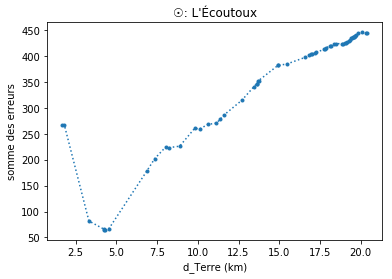

In [64]:
# - test -
soleil = 'Moucherotte' 
soleil = "L'Écoutoux"
#soleil = 'Grand Veymont'

sorted_name, sorted_dist = get_alldistfromsun( soleil )

d_span = sorted_dist[1:60]
error_span = [ get_errorsum( sorted_dist,  d ) for d in d_span ]

plt.plot( d_span, error_span, '.:'  );
plt.xlabel('d_Terre (km)'); plt.ylabel('somme des erreurs'); plt.title('☉: %s'%soleil);

In [21]:
def get_best_d( soleil ):
    """ Recherche (brute) du meilleur facteur de proportion pour un soleil donné
    """
    sorted_name, sorted_dist = get_alldistfromsun( soleil )

    d_span = sorted_dist[1:60]
    error_span = np.array([ get_errorsum( sorted_dist,  d ) for d in d_span ])
    
    i_min =  np.argmin( error_span )
    
    return d_span[ i_min ], error_span[ i_min ]

In [22]:
get_best_d( soleil )

(4.3660637353824905, 52.906691569196958)

# Recherche du 'soleil'

## Sommets les plus proches de Grenoble

On cherche un endroit autour de Grenoble. Les sommets sont donc testés, dans l'ordre, en commançant par le plus proche. 

In [23]:
# position de Grenoble
lat_Gre, lon_Gre = 45.166672, 5.71667 

# liste ordonnée des distances :
name_nearGre, dist_nearGre = get_alldistfromcoords( lat_Gre, lon_Gre , visibleonly=False )

In [28]:
print ( ', '.join( [ '%s (%.2f km)'%x for x in zip( name_nearGre, dist_nearGre ) ][:10]) )

Mont Jalla (4.19 km), Mont Rachais (5.91 km), Les 3 Pucelles (6.03 km), Mollard Gargot (6.30 km), Moucherotte (6.42 km), Le Fournet (6.58 km), Les Quatre Seigneurs (7.05 km), Le Néron (7.58 km), Bellevue (8.41 km), Saint-Eynard (8.53 km)


In [48]:
from IPython.display import clear_output

def affiche_scores( tableau ):
    clear_output()
    for soleil, d_and_error in tableau[:10]:
        d_Terre_opti, error = d_and_error
        print( '{0:>35}: {1:3.2f}    erreur cumulée={2:7.1f}%'.format(soleil, d_Terre_opti, error ) )

### Calcul pour les sommets proche de Grenoble:

In [70]:
N = 40
tableau_scores = []
for soleil in name_nearGre[:N] :
    tableau_scores.append( (soleil, get_best_d( soleil )) )
    tableau_scores.sort( key=lambda x:x[1][1] )

    affiche_scores( tableau_scores )
    
print('done N=', N)

                Croix de Chamrousse: 2.19    erreur cumulée=   40.9%
                       Saint-Eynard: 3.96    erreur cumulée=   42.1%
                  Rochers de l'Ours: 2.63    erreur cumulée=   62.3%
                         L'Écoutoux: 4.28    erreur cumulée=   64.3%
                 Rochers de Chalves: 3.36    erreur cumulée=   66.9%
                           La Buffe: 3.24    erreur cumulée=   76.3%
                       Grand Eulier: 3.02    erreur cumulée=   79.7%
                   Pic Saint-Michel: 4.26    erreur cumulée=   84.6%
                           La Pinéa: 3.91    erreur cumulée=   90.5%
                      Roc Cornafion: 4.00    erreur cumulée=   97.1%
done N= 40


## Pour un sommet en particulier
Maintenant, en choisisant un sommet pour le 'soleil', on peut lister les autres sommets correspondant aux planètes :

In [144]:
k = 0
soleil = tableau_scores[k][0]
print( soleil )

Croix de Chamrousse


In [145]:
## Calcul : 
sorted_name, sorted_dist = get_alldistfromsun( soleil )

Pour un même soleil il peut avoir plusieurs solution. L'erreur la plus faible n'est pas forcement la mieux. Il peut être plus intéressant d'avoir des sommets plus proche ou bien plus remarquables.

In [146]:
# Recherche de la meilleur Terre sur les sommets autour du soleil
best_Earth = [ (name, d, get_errorsum( sorted_dist,  d )) for name, d in zip(sorted_name, sorted_dist) if name!=soleil ]
best_Earth = sorted( best_Earth, key= lambda x:x[2] )

In [161]:
best_Earth[:8]

for i, (name, distance, error) in enumerate( best_Earth[:8] ):
    print( i, '- {0:25} {1:2.2f}km    erreur:{2:3.1f}%'.format(name, distance,  error) )

0 - Petit Van                 2.19km    erreur:40.9%
1 - Grand Eulier              1.61km    erreur:48.3%
2 - Grand Van                 2.29km    erreur:51.2%
3 - Pointe de Jasse Bralard   3.19km    erreur:68.9%
4 - Pointe de Vaudaine        2.83km    erreur:90.1%
5 - Grand Colon               4.55km    erreur:135.9%
6 - Pic de Mirebel            4.63km    erreur:140.8%
7 - Montrond                  4.71km    erreur:147.8%


In [152]:
k = 0
d_Terre = best_Earth[k][1]

# Liste sommet - planète
print('soleil : %s \n'% soleil )

print( '{0:>10}  {1:40} {2}   {3}'.format('Planète', 'Sommet',  'Erreur(%)', 'Distance(km)') )
print( '-----------------------------------------------------------------------------' )

for i, n in enumerate( planetes_noms ):
    d_UA = planetes_UA[i]
    pic_proche, erreur, d_reel = findnearest_disp(sorted_name, sorted_dist, d_UA * d_Terre )
    
    alt = get_alt( dicosommets[pic_proche] )
    pic_name = '%s (%im)'%(pic_proche, alt)
    print( '{0:>10}: {1:40} {2:7.2f}    {3:7.1f}'.format(n, pic_name,  erreur, d_reel) )

soleil : Croix de Chamrousse 

   Planète  Sommet                                   Erreur(%)   Distance(km)
-----------------------------------------------------------------------------
   Mercure: Rocher de la Perche (2152m)                25.78        0.7
     Vénus: Grand Eulier (2232m)                        1.53        1.6
     Terre: Petit Van (2439m)                           0.00        2.2
      Mars: Pointe de Jasse Bralard (2491m)             4.83        3.2
     Cérès: Grand Galbert (2561m)                       1.97        6.0
   Jupiter: Bellevue (733m)                             3.96       11.0
   Saturne: Les 3 Pucelles (1456m)                      0.42       21.0
    Uranus: Dôme de Neige des Écrins (4015m)            0.43       41.9
   Neptune: Le Trélod (2181m)                           1.63       67.1
    Pluton: Grand Colombier (1534m)                     0.33       86.9


### Affichage sur une carte

Avec le module python `folium`, qui utilise la librairie javascript `leaflet.js` et _openstreetmap_, il est possible d'afficher une carte dans le notebook.

http://python-visualization.github.io/folium/  
https://github.com/python-visualization/folium

In [153]:
# Creation de la carte
s = dicosommets[ soleil ]
coords_soleil = [   s['lat'], s['lon'] ]

solar_map = folium.Map(location=coords_soleil, zoom_start=12, tiles='Stamen Terrain')

In [154]:
# Ajout des planètes :
for i, n in enumerate( planetes_noms ):
    d_UA = planetes_UA[i]
    pic_proche, erreur, d_reel = findnearest_disp(sorted_name, sorted_dist, d_UA * d_Terre )
    
    s = dicosommets[ pic_proche ]
    coords = [s['lat'], s['lon']]
    
    # ligne soleil - planete
    lines = [coords_soleil, coords]
    folium.features.PolyLine(lines, opacity=0.4, color='black').add_to(solar_map)
    
    # marker
    popuptext = '%s - %s' %(pic_proche, n)
    folium.CircleMarker(location=coords, radius=5,  popup=popuptext, \
                    fill_color='blue', color='blue').add_to(solar_map);
    
# soleil 
popuptext = 'Soleil: %s' % soleil
folium.CircleMarker(location=coords_soleil, radius=7,  popup=popuptext, \
                    fill_color='yellow', color='yellow').add_to(solar_map);

In [155]:
# Affiche la carte
solar_map

In [34]:
# enregistre la carte
solar_map.save('solar_map.html')

[voir la carte](./solar_map.html)

# Pour la suite

- [ok] Calcul de l'horizon, pour réduire le nombre de candidats
- Taille des planètes et du soleil à l'échelle

- recherche non systématique, mais intelligente :  le sommet visible plus loin est le Mont-Blanc, donc ce doit être Neptune ...
- Rechercher les seconds, 3ième ... etc minimums  qui peuvent être plus remarquable que le premier...

- placement des lunes
- Carte avec symboles 
